# Импорт библиотек и функции

In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow import keras
from keras import layers

from keras.callbacks import EarlyStopping

from sklearn.metrics import confusion_matrix, balanced_accuracy_score, roc_auc_score, precision_recall_fscore_support, roc_curve, auc, classification_report
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

In [39]:
def plot_training_curves(history):

  tr_acc = history.history['accuracy']
  tr_loss = history.history['loss']
  val_acc = history.history['val_accuracy']
  val_loss = history.history['val_loss']
  index_loss = np.argmin(val_loss)
  val_lowest = val_loss[index_loss]
  index_acc = np.argmax(val_acc)
  acc_highest = val_acc[index_acc]
  epochs = [i+1 for i in range(len(tr_acc))] # количество эпох обучения
  loss_label = f'best epoch = {str(index_loss + 1)}'
  acc_label = f'best epoch = {str(index_acc + 1)}'

  # Plot training history
  plt.figure(figsize= (12, 5))
  plt.style.use('fivethirtyeight')

  plt.subplot(1, 2, 1)
  plt.plot(epochs, tr_loss, 'r', label='Ошибка обучения')
  plt.plot(epochs, val_loss, 'g', label='Ошибка валидации')
  plt.scatter(index_loss + 1, val_lowest, s=150, c= 'blue', label=loss_label)
  plt.title('Ошибка при обучении и валидации', fontsize=14, fontweight="bold")
  plt.xlabel('Эпохи', fontsize=12)
  plt.ylabel('Значение ошибки', fontsize=12)
  plt.legend(fontsize=12)

  plt.subplot(1, 2, 2)
  plt.plot(epochs, tr_acc, 'r', label='Точность обучения')
  plt.plot(epochs, val_acc, 'g', label='Точность валидации')
  plt.scatter(index_acc + 1 , acc_highest, s=150, c= 'blue', label=acc_label)
  plt.title('Точность при обучении и валидации', fontsize=14, fontweight="bold")
  plt.xlabel('Эпохи', fontsize=12)
  plt.ylabel('Значение точности', fontsize=12)
  plt.legend(fontsize=12)

  plt.tight_layout
  plt.show()

  return

def plot_confusion_matrix(y_true, y_pred, classes='auto', figsize=(10, 10), text_size=12):
  # подсчет матрицы ощибок
  cm = confusion_matrix(y_true, y_pred)

  # размер изображения
  plt.figure(figsize=figsize)

  # визуалиазиция матрицы ощибок
  disp = sns.heatmap(
      cm, annot=True, cbar=False,
      annot_kws={"size": text_size}, fmt='g',
      linewidths=.5, linecolor='black', clip_on=False,
      xticklabels=classes, yticklabels=classes)

  disp.set_title('Матрица ощибок', fontsize=14, fontweight="bold")
  disp.set_xlabel('Предсказанные значения', fontsize=12)
  disp.set_ylabel('Истинные значения', fontsize=12)
  plt.yticks(rotation=0)

  plt.show()

  return

# Функция для подсчета метрик модели классификации
def generate_preformance_scores(y_true, y_pred, y_probabilities):

  cm = confusion_matrix(y_true, y_pred)
  accuracy_per_class = cm.diagonal() / cm.sum(axis=1)
  model_accuracy = balanced_accuracy_score(y_true, y_pred)
  model_precision, model_recall, _, _ = precision_recall_fscore_support(y_true,
                                                                                y_pred,
                                                                                average="weighted")
  model_roc_auc = roc_auc_score(y_true, y_probabilities, multi_class="ovr")

  print(f'Accuracy Score:\t\t{model_accuracy:.4f}')
  print(f'Precision_score:\t{model_precision:.4f}')
  print(f'Recall_score:\t\t{model_recall:.4f}')
  print(f'AUC Score:\t\t{model_roc_auc:.4f}')
  print("")
  for i in range(len(accuracy_per_class)):
    print(f"Accuracy Score {i}:\t{accuracy_per_class[i]:.4f}")
  print("")
  print(classification_report(y_true, y_pred))

  preformance_scores = {
      'accuracy_score': model_accuracy,
      'precision_score': model_precision,
      'recall_score': model_recall,
      'auc_score': model_roc_auc
  }

  return preformance_scores


def plot_multiclass_roc(y_test, y_prob, n_classes, figsize=(5,5)):
    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    y_test_dummies = pd.get_dummies(y_test, drop_first=False).values

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([-0.01, 1.0])
    ax.set_ylim([0.0, 1.01])
    ax.set_xlabel('False Positive Rate', fontsize=12)
    ax.set_ylabel('True Positive Rate', fontsize=12)
    ax.set_title("График ROC-кривой", fontsize=14, fontweight="bold")
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='AUC = %0.3f for label %i' % (roc_auc[i], i))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    plt.show()

# Загрузка набора данных

In [3]:
# получение токена для загрузки набора данных с сайта kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"dashkabugashka","key":"120cb24fa13253988e528a5054fa0b13"}'}

In [4]:
!ls -lha kaggle.json

-rw-r--r-- 1 root root 70 Oct 30 03:24 kaggle.json


In [5]:
# Next, install the Kaggle API client.
!pip install -q kaggle

In [6]:
# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [7]:
!kaggle datasets download -d kukuroo3/body-performance-data

  0% 0.00/249k [00:00<?, ?B/s]
100% 249k/249k [00:00<00:00, 119MB/s]


# Чтение данных

In [8]:
# разархивирование данных
!unzip "/content/body-performance-data.zip" -d "/content/body"

Archive:  /content/body-performance-data.zip
  inflating: /content/body/bodyPerformance.csv  


In [9]:
df = pd.read_csv('/content/body/bodyPerformance.csv') # читаем данные в перменную df
df.head() # выводим первые 5 строк

,age,gender,height_cm,weight_kg,body fat_%,diastolic,systolic,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm,class
0,27.0,M,172.3,75.24,21.3,80.0,130.0,54.9,18.4,60.0,217.0,C
1,25.0,M,165.0,55.80,15.7,77.0,126.0,36.4,16.3,53.0,229.0,A
2,31.0,M,179.6,78.00,20.1,92.0,152.0,44.8,12.0,49.0,181.0,C
3,32.0,M,174.5,71.10,18.4,76.0,147.0,41.4,15.2,53.0,219.0,B
4,28.0,M,173.8,67.70,17.1,70.0,127.0,43.5,27.1,45.0,217.0,B


# Исследование данных

In [10]:
df = df.rename(columns={"body fat_%": "body_fat",
                        "sit and bend forward_cm": "sit_bend_forward_cm",
                        "sit-ups counts": "sit_ups_counts",
                        "broad jump_cm": "broad_jump_cm"}
          )
df.head()

,age,gender,height_cm,weight_kg,body_fat,diastolic,systolic,gripForce,sit_bend_forward_cm,sit_ups_counts,broad_jump_cm,class
0,27.0,M,172.3,75.24,21.3,80.0,130.0,54.9,18.4,60.0,217.0,C
1,25.0,M,165.0,55.80,15.7,77.0,126.0,36.4,16.3,53.0,229.0,A
2,31.0,M,179.6,78.00,20.1,92.0,152.0,44.8,12.0,49.0,181.0,C
3,32.0,M,174.5,71.10,18.4,76.0,147.0,41.4,15.2,53.0,219.0,B
4,28.0,M,173.8,67.70,17.1,70.0,127.0,43.5,27.1,45.0,217.0,B


In [11]:
lb = LabelEncoder()
df['class'] = lb.fit_transform(df['class'])
class_names = lb.classes_

In [12]:
df = df.replace({'M':0, 'F':1})

In [13]:
df.describe() # информация о числовых характеристиках переменных

,age,gender,height_cm,weight_kg,body_fat,diastolic,systolic,gripForce,sit_bend_forward_cm,sit_ups_counts,broad_jump_cm,class
count,13393.000000,13393.000000,13393.000000,13393.000000,13393.000000,13393.000000,13393.000000,13393.000000,13393.000000,13393.000000,13393.000000,13393.000000
mean,36.775106,0.367804,168.559807,67.447316,23.240165,78.796842,130.234817,36.963877,15.209268,39.771224,190.129627,1.500187
std,13.625639,0.482226,8.426583,11.949666,7.256844,10.742033,14.713954,10.624864,8.456677,14.276698,39.868000,1.118109
min,21.000000,0.000000,125.000000,26.300000,3.000000,0.000000,0.000000,0.000000,-25.000000,0.000000,0.000000,0.000000
25%,25.000000,0.000000,162.400000,58.200000,18.000000,71.000000,120.000000,27.500000,10.900000,30.000000,162.000000,1.000000
50%,32.000000,0.000000,169.200000,67.400000,22.800000,79.000000,130.000000,37.900000,16.200000,41.000000,193.000000,2.000000
75%,48.000000,1.000000,174.800000,75.300000,28.000000,86.000000,141.000000,45.200000,20.700000,50.000000,221.000000,3.000000
max,64.000000,1.000000,193.800000,138.100000,78.400000,156.200000,201.000000,70.500000,213.000000,80.000000,303.000000,3.000000


In [14]:
df.info() # информация о пропущенных знначениях и типах переменной

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13393 entries, 0 to 13392
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  13393 non-null  float64
 1   gender               13393 non-null  int64  
 2   height_cm            13393 non-null  float64
 3   weight_kg            13393 non-null  float64
 4   body_fat             13393 non-null  float64
 5   diastolic            13393 non-null  float64
 6   systolic             13393 non-null  float64
 7   gripForce            13393 non-null  float64
 8   sit_bend_forward_cm  13393 non-null  float64
 9   sit_ups_counts       13393 non-null  float64
 10  broad_jump_cm        13393 non-null  float64
 11  class                13393 non-null  int64  
dtypes: float64(10), int64(2)
memory usage: 1.2 MB


In [16]:
df.duplicated().sum()

1

In [17]:
df = df.drop_duplicates()
df.duplicated().sum()

0

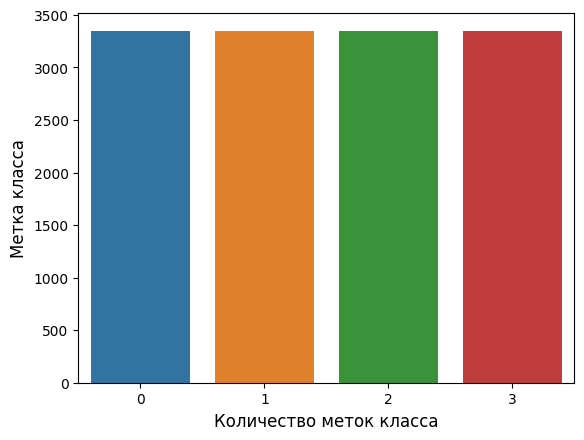

In [ ]:
# визуализация количества меток класса
sns.countplot(x=df['class'] ,data=df)
plt.xlabel("Количество меток класса", fontsize=12)
plt.ylabel("Метка класса", fontsize=12)
plt.show()

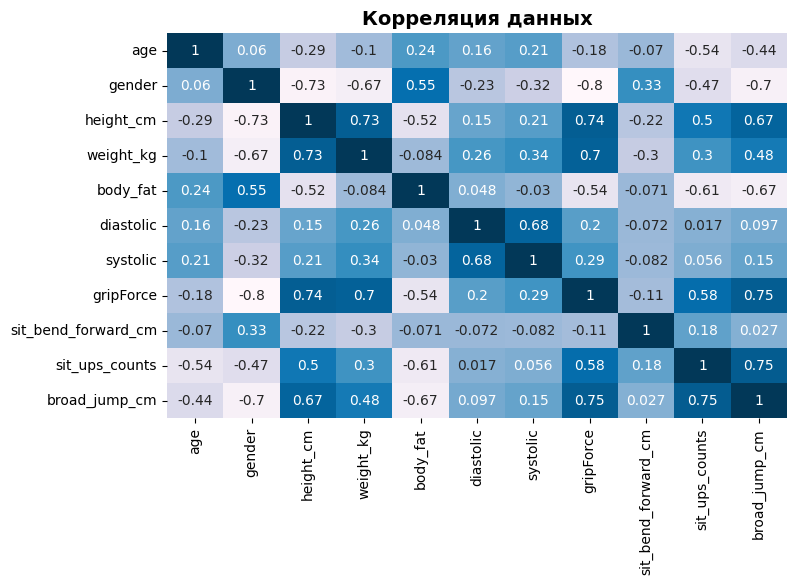

In [18]:
plt.figure(figsize = (8, 5))
sns.heatmap(df.drop("class", axis=1).corr(), annot=True, cmap ='PuBu', cbar=False)
plt.title("Корреляция данных", fontsize=14, fontweight="bold");

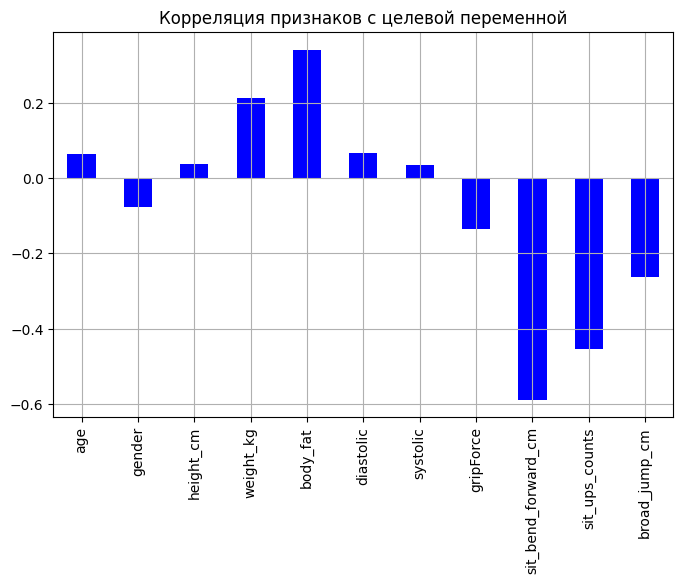

In [19]:
df.drop('class', axis=1).corrwith(df["class"]).plot(kind='bar',
                                                    grid=True,
                                                    figsize=(8, 5),
                                                    title="Корреляция признаков с целевой переменной",
                                                    color="blue");

In [21]:
corr = df.corr()
th=0.2

corr_th = corr["class"][abs(corr["class"]) > th]
corr_th

weight_kg              0.214008
body_fat               0.342095
sit_bend_forward_cm   -0.588115
sit_ups_counts        -0.452794
broad_jump_cm         -0.262233
class                  1.000000
Name: class, dtype: float64

In [22]:
df_new_features = df.drop(corr["class"][abs(corr["class"]) <= th].keys(), axis=1)
df_new_features.head()

,weight_kg,body_fat,sit_bend_forward_cm,sit_ups_counts,broad_jump_cm,class
0,75.24,21.3,18.4,60.0,217.0,2
1,55.80,15.7,16.3,53.0,229.0,0
2,78.00,20.1,12.0,49.0,181.0,2
3,71.10,18.4,15.2,53.0,219.0,1
4,67.70,17.1,27.1,45.0,217.0,1


# Деление на выборки

In [23]:
# делим выборку на тренировочную и тестовую
X = df.drop(['class'],axis=1).values # удаляем целевую переменную из общего набора данных
y = df['class'].values # создаем отделтнуб переменную для целевого признака
X_all_train, X_test, y_all_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0) # делим набор данных на тренировочный и тестовый в соотношениии 80/20 (train/test)
X_train, X_val, y_train, y_val = train_test_split(X_all_train, y_all_train, test_size = 0.2, random_state = 0) # делим набор данных на тренировочный и валидационный в соотношениии 80/20 (train/test)

In [24]:
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

In [25]:
print(f"Размер тренировочной выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")
print(f"Размер валидационной выборки: {X_val.shape}")

Размер тренировочной выборки: (8570, 11)
Размер тестовой выборки: (2679, 11)
Размер валидационной выборки: (2143, 11)


In [26]:
# проводим стандартизацию данных, для лучшей работы нейронной сети
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Создание модели

In [27]:
early_stop = EarlyStopping(monitor='val_accuracy', patience=10, mode='max', verbose=1)

callbacks_list=[early_stop]

## Модель 1

In [28]:
model1 = keras.Sequential([
    layers.Dense(12, input_dim=X_train.shape[1], activation="relu"),
    layers.Dense(8, activation="relu"),
    layers.Dense(4, activation="relu"),
    layers.Dense(len(class_names), activation="softmax")
])

In [29]:
# компиляция модели
model1.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12)                144       
                                                                 
 dense_1 (Dense)             (None, 8)                 104       
                                                                 
 dense_2 (Dense)             (None, 4)                 36        
                                                                 
 dense_3 (Dense)             (None, 4)                 20        
                                                                 
Total params: 304 (1.19 KB)
Trainable params: 304 (1.19 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Обучение

In [30]:
history1 = model1.fit(X_train,
                      y_train,
                      epochs=150,
                      batch_size=32,
                      validation_data=(X_val, y_val),
                      callbacks=callbacks_list
                      )

Epoch 1/150
268/268 [==============================] - 3s 6ms/step - loss: 1.2747 - accuracy: 0.3764 - val_loss: 1.0887 - val_accuracy: 0.4993
Epoch 2/150
268/268 [==============================] - 1s 4ms/step - loss: 0.9748 - accuracy: 0.5469 - val_loss: 0.9135 - val_accuracy: 0.5922
Epoch 3/150
268/268 [==============================] - 1s 3ms/step - loss: 0.8688 - accuracy: 0.6120 - val_loss: 0.8593 - val_accuracy: 0.6099
Epoch 4/150
268/268 [==============================] - 1s 3ms/step - loss: 0.8299 - accuracy: 0.6344 - val_loss: 0.8258 - val_accuracy: 0.6258
Epoch 5/150
268/268 [==============================] - 1s 4ms/step - loss: 0.8027 - accuracy: 0.6489 - val_loss: 0.8001 - val_accuracy: 0.6547
Epoch 6/150
268/268 [==============================] - 1s 3ms/step - loss: 0.7809 - accuracy: 0.6637 - val_loss: 0.7802 - val_accuracy: 0.6710
Epoch 7/150
268/268 [==============================] - 1s 2ms/step - loss: 0.7614 - accuracy: 0.6718 - val_loss: 0.7761 - val_accuracy: 0.6701

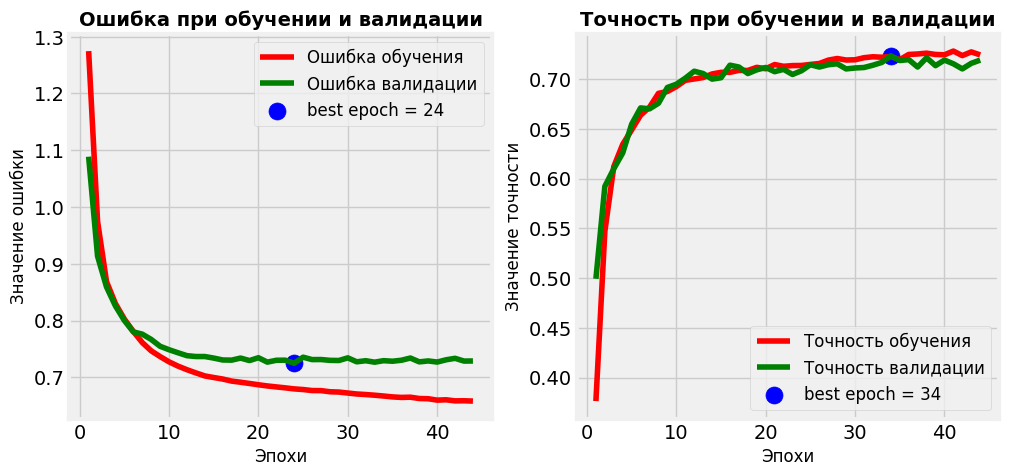

In [33]:
plot_training_curves(history1)

In [34]:
y_predicted_prob = model1.predict(X_test) # обучения модели на тестовом наборе
y_predicted = np.argmax(y_predicted_prob, axis=1) # перевод вероятностей в метки [0, 1] с порогом 0.5

84/84 [==============================] - 0s 1ms/step


In [35]:
model1_preformance = generate_preformance_scores(y_test, y_predicted, y_predicted_prob)

Accuracy Score:		0.7161
Precision_score:	0.7230
Recall_score:		0.7159
AUC Score:		0.9064

Accuracy Score 0:	0.8902
Accuracy Score 1:	0.5331
Accuracy Score 2:	0.6697
Accuracy Score 3:	0.7713

              precision    recall  f1-score   support

           0       0.69      0.89      0.78       674
           1       0.61      0.53      0.57       679
           2       0.67      0.67      0.67       657
           3       0.92      0.77      0.84       669

    accuracy                           0.72      2679
   macro avg       0.72      0.72      0.71      2679
weighted avg       0.72      0.72      0.71      2679



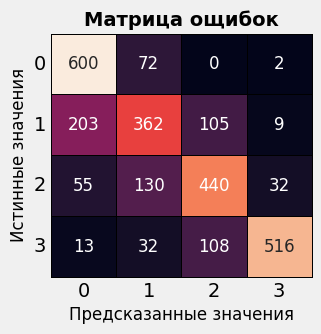

In [40]:
plot_confusion_matrix(y_test, y_predicted, figsize=(3, 3))

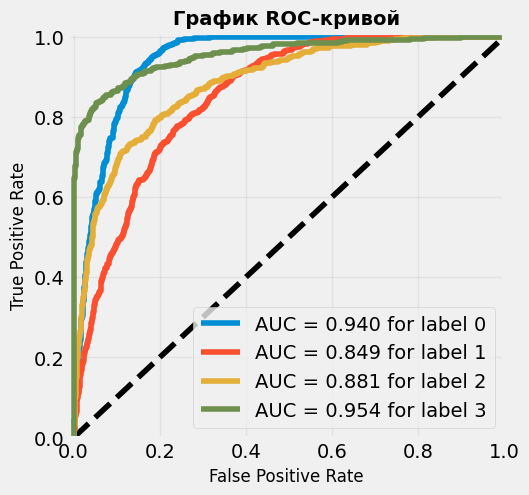

In [38]:
plot_multiclass_roc(y_test, y_predicted_prob, 4)

## Модель 2

In [41]:
model2 = keras.Sequential([
    layers.Dense(12, input_dim=X_train.shape[1], activation="relu"),
    layers.Dense(len(class_names), activation="softmax")
])

In [42]:
# компиляция модели
model2.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 12)                144       
                                                                 
 dense_5 (Dense)             (None, 4)                 52        
                                                                 
Total params: 196 (784.00 Byte)
Trainable params: 196 (784.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Обучение

In [43]:
history2 = model2.fit(X_train,
                      y_train,
                      epochs=150,
                      batch_size=32,
                      validation_data=(X_val, y_val),
                      callbacks=callbacks_list
                      )

Epoch 1/150
268/268 [==============================] - 2s 4ms/step - loss: 1.4151 - accuracy: 0.3106 - val_loss: 1.1999 - val_accuracy: 0.4503
Epoch 2/150
268/268 [==============================] - 1s 3ms/step - loss: 1.0851 - accuracy: 0.5215 - val_loss: 1.0084 - val_accuracy: 0.5548
Epoch 3/150
268/268 [==============================] - 1s 5ms/step - loss: 0.9596 - accuracy: 0.5756 - val_loss: 0.9348 - val_accuracy: 0.5721
Epoch 4/150
268/268 [==============================] - 1s 5ms/step - loss: 0.9038 - accuracy: 0.5918 - val_loss: 0.8949 - val_accuracy: 0.5940
Epoch 5/150
268/268 [==============================] - 1s 4ms/step - loss: 0.8729 - accuracy: 0.6107 - val_loss: 0.8706 - val_accuracy: 0.6015
Epoch 6/150
268/268 [==============================] - 2s 8ms/step - loss: 0.8536 - accuracy: 0.6179 - val_loss: 0.8562 - val_accuracy: 0.6132
Epoch 7/150
268/268 [==============================] - 1s 3ms/step - loss: 0.8400 - accuracy: 0.6272 - val_loss: 0.8449 - val_accuracy: 0.6188

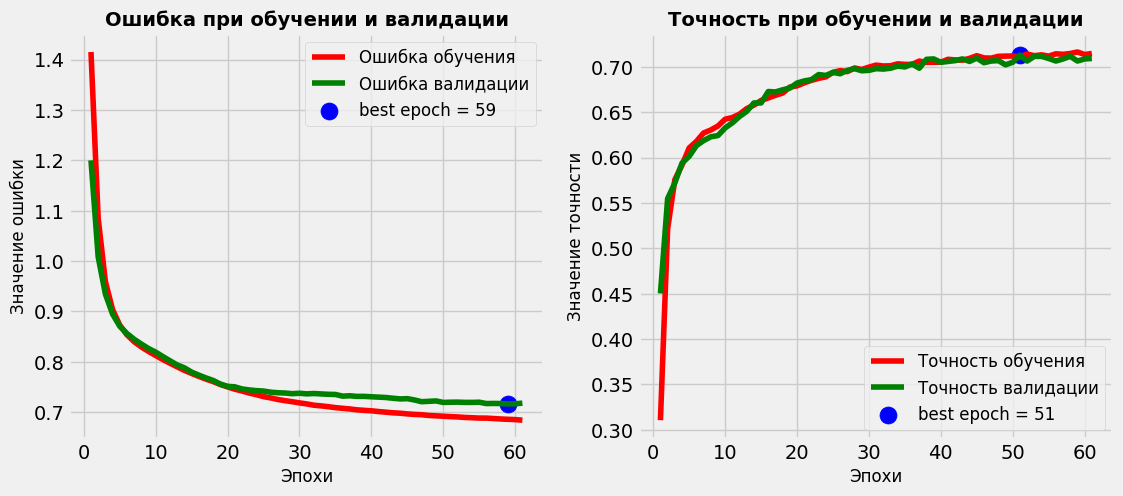

In [44]:
plot_training_curves(history2)

In [45]:
y_predicted_prob = model2.predict(X_test) # обучения модели на тестовом наборе
y_predicted = np.argmax(y_predicted_prob, axis=1) # перевод вероятностей в метки [0, 1] с порогом 0.5

84/84 [==============================] - 0s 2ms/step


In [46]:
model2_preformance = generate_preformance_scores(y_test, y_predicted, y_predicted_prob)

Accuracy Score:		0.6977
Precision_score:	0.6941
Recall_score:		0.6976
AUC Score:		0.8996

Accuracy Score 0:	0.8353
Accuracy Score 1:	0.5214
Accuracy Score 2:	0.6180
Accuracy Score 3:	0.8161

              precision    recall  f1-score   support

           0       0.71      0.84      0.77       674
           1       0.57      0.52      0.55       679
           2       0.66      0.62      0.64       657
           3       0.83      0.82      0.82       669

    accuracy                           0.70      2679
   macro avg       0.69      0.70      0.69      2679
weighted avg       0.69      0.70      0.69      2679



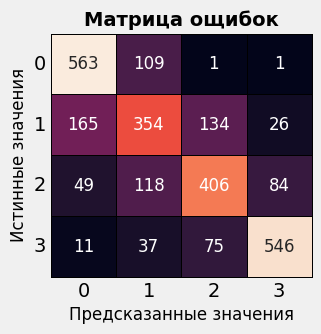

In [47]:
plot_confusion_matrix(y_test, y_predicted, figsize=(3, 3))

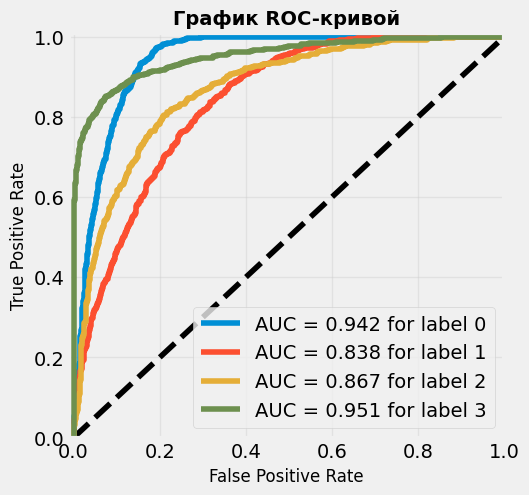

In [48]:
plot_multiclass_roc(y_test, y_predicted_prob, 4)

## Модель 2 оптимизатор RMSprop

In [49]:
model1_rms = keras.Sequential([
    layers.Dense(12, input_dim=X_train.shape[1], activation="relu"),
    layers.Dense(8, activation="relu"),
    layers.Dense(4, activation="relu"),
    layers.Dense(len(class_names), activation="softmax")
])

In [50]:
# компиляция модели
model1_rms.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
              loss="categorical_crossentropy",
              metrics=["accuracy"])
model1_rms.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 12)                144       
                                                                 
 dense_7 (Dense)             (None, 8)                 104       
                                                                 
 dense_8 (Dense)             (None, 4)                 36        
                                                                 
 dense_9 (Dense)             (None, 4)                 20        
                                                                 
Total params: 304 (1.19 KB)
Trainable params: 304 (1.19 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Обучение

In [51]:
history1_rms = model1_rms.fit(X_train,
                      y_train,
                      epochs=150,
                      batch_size=32,
                      validation_data=(X_val, y_val),
                      callbacks=callbacks_list
                      )

Epoch 1/150
268/268 [==============================] - 2s 5ms/step - loss: 1.3607 - accuracy: 0.3169 - val_loss: 1.2628 - val_accuracy: 0.4340
Epoch 2/150
268/268 [==============================] - 1s 3ms/step - loss: 1.0641 - accuracy: 0.5364 - val_loss: 0.9513 - val_accuracy: 0.5688
Epoch 3/150
268/268 [==============================] - 1s 3ms/step - loss: 0.9114 - accuracy: 0.5954 - val_loss: 0.8882 - val_accuracy: 0.5917
Epoch 4/150
268/268 [==============================] - 1s 3ms/step - loss: 0.8647 - accuracy: 0.6109 - val_loss: 0.8491 - val_accuracy: 0.6141
Epoch 5/150
268/268 [==============================] - 1s 4ms/step - loss: 0.8340 - accuracy: 0.6289 - val_loss: 0.8242 - val_accuracy: 0.6295
Epoch 6/150
268/268 [==============================] - 2s 6ms/step - loss: 0.8111 - accuracy: 0.6412 - val_loss: 0.8039 - val_accuracy: 0.6449
Epoch 7/150
268/268 [==============================] - 1s 5ms/step - loss: 0.7926 - accuracy: 0.6548 - val_loss: 0.7855 - val_accuracy: 0.6580

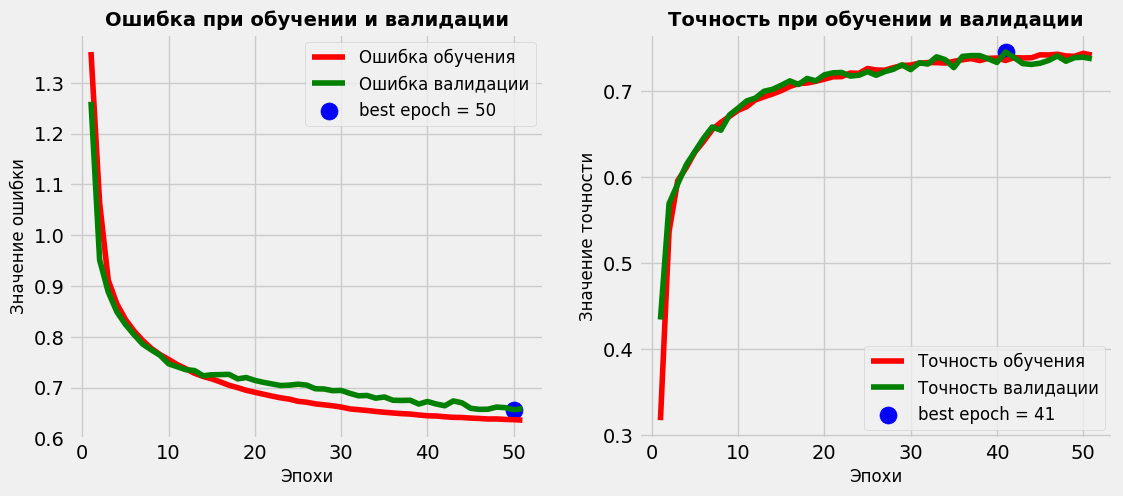

In [52]:
plot_training_curves(history1_rms)

In [53]:
y_predicted_prob = model1_rms.predict(X_test) # обучения модели на тестовом наборе
y_predicted = np.argmax(y_predicted_prob, axis=1) # перевод вероятностей в метки [0, 1] с порогом 0.5

84/84 [==============================] - 0s 2ms/step


In [54]:
model1_rms_preformance = generate_preformance_scores(y_test, y_predicted, y_predicted_prob)

Accuracy Score:		0.7360
Precision_score:	0.7434
Recall_score:		0.7361
AUC Score:		0.9126

Accuracy Score 0:	0.8427
Accuracy Score 1:	0.6274
Accuracy Score 2:	0.6591
Accuracy Score 3:	0.8146

              precision    recall  f1-score   support

           0       0.73      0.84      0.78       674
           1       0.59      0.63      0.61       679
           2       0.75      0.66      0.70       657
           3       0.91      0.81      0.86       669

    accuracy                           0.74      2679
   macro avg       0.74      0.74      0.74      2679
weighted avg       0.74      0.74      0.74      2679



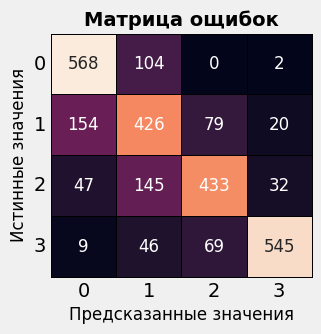

In [55]:
plot_confusion_matrix(y_test, y_predicted, figsize=(3, 3))

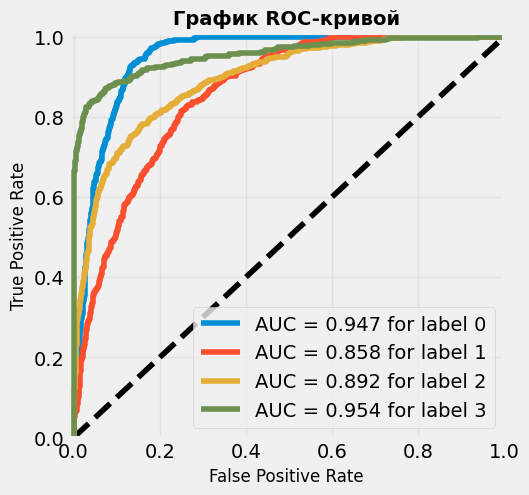

In [56]:
plot_multiclass_roc(y_test, y_predicted_prob, 4)

## Модель 3 оптимизатор RMSprop

In [57]:
model3 = keras.Sequential([
    layers.Dense(16, input_dim=X_train.shape[1], activation="relu"),
    layers.Dense(32, activation="relu"),
    layers.Dropout(0.4),
    layers.Dense(32, activation="relu"),
    layers.Dropout(0.4),
    layers.Dense(16, activation="relu"),
    layers.Dense(4, activation="softmax")
])

In [58]:
# компиляция модели
model3.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
              loss="categorical_crossentropy",
              metrics=["accuracy"])
model3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 16)                192       
                                                                 
 dense_11 (Dense)            (None, 32)                544       
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_12 (Dense)            (None, 32)                1056      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_13 (Dense)            (None, 16)                528       
                                                                 
 dense_14 (Dense)            (None, 4)                

### Обучение

In [59]:
history3 = model3.fit(X_train,
                      y_train,
                      epochs=150,
                      batch_size=32,
                      validation_data=(X_val, y_val),
                      callbacks=callbacks_list
                      )

Epoch 1/150
268/268 [==============================] - 3s 5ms/step - loss: 1.2416 - accuracy: 0.3926 - val_loss: 1.0508 - val_accuracy: 0.5072
Epoch 2/150
268/268 [==============================] - 1s 3ms/step - loss: 1.0329 - accuracy: 0.5142 - val_loss: 0.9454 - val_accuracy: 0.5702
Epoch 3/150
268/268 [==============================] - 1s 2ms/step - loss: 0.9665 - accuracy: 0.5599 - val_loss: 0.9020 - val_accuracy: 0.5922
Epoch 4/150
268/268 [==============================] - 1s 3ms/step - loss: 0.9242 - accuracy: 0.5789 - val_loss: 0.8723 - val_accuracy: 0.6062
Epoch 5/150
268/268 [==============================] - 2s 6ms/step - loss: 0.8956 - accuracy: 0.5929 - val_loss: 0.8518 - val_accuracy: 0.6276
Epoch 6/150
268/268 [==============================] - 2s 7ms/step - loss: 0.8747 - accuracy: 0.6098 - val_loss: 0.8401 - val_accuracy: 0.6365
Epoch 7/150
268/268 [==============================] - 2s 6ms/step - loss: 0.8631 - accuracy: 0.6173 - val_loss: 0.8138 - val_accuracy: 0.6440

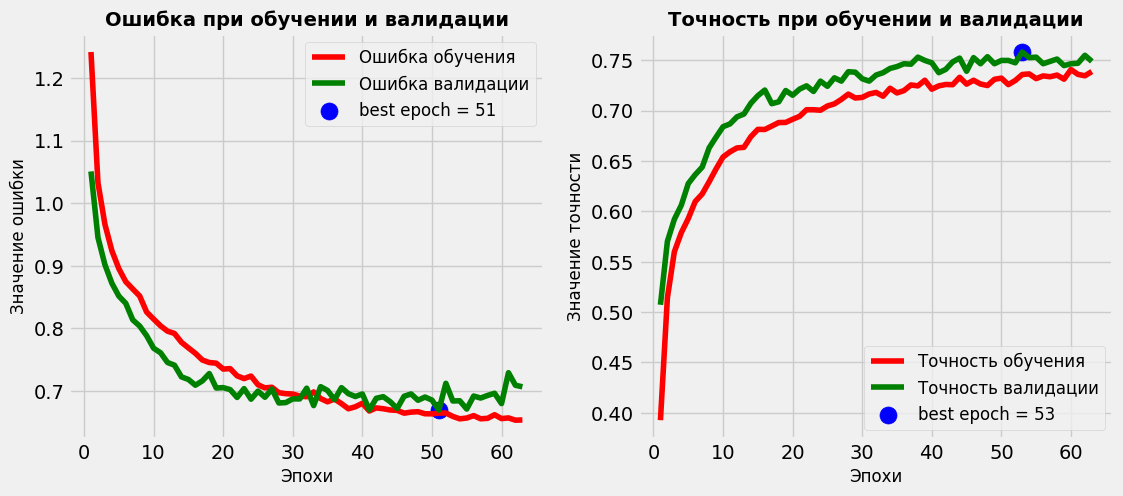

In [60]:
plot_training_curves(history3)

In [61]:
y_predicted_prob = model3.predict(X_test) # обучения модели на тестовом наборе
y_predicted = np.argmax(y_predicted_prob, axis=1) # перевод вероятностей в метки [0, 1] с порогом 0.5

84/84 [==============================] - 0s 1ms/step


In [62]:
model3_performance = generate_preformance_scores(y_test, y_predicted, y_predicted_prob)

Accuracy Score:		0.7293
Precision_score:	0.7461
Recall_score:		0.7297
AUC Score:		0.9151

Accuracy Score 0:	0.8828
Accuracy Score 1:	0.6406
Accuracy Score 2:	0.6134
Accuracy Score 3:	0.7803

              precision    recall  f1-score   support

           0       0.70      0.88      0.78       674
           1       0.59      0.64      0.61       679
           2       0.76      0.61      0.68       657
           3       0.94      0.78      0.85       669

    accuracy                           0.73      2679
   macro avg       0.75      0.73      0.73      2679
weighted avg       0.75      0.73      0.73      2679



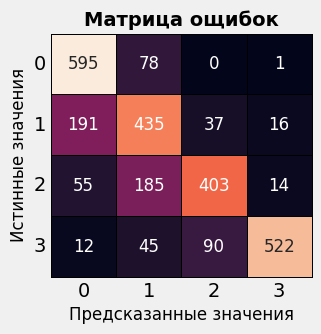

In [63]:
plot_confusion_matrix(y_test, y_predicted, figsize=(3, 3))

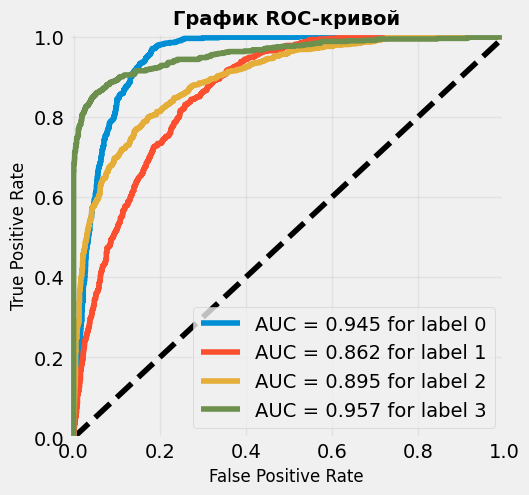

In [64]:
plot_multiclass_roc(y_test, y_predicted_prob, 4)

# Деление на выборки

In [65]:
# делим выборку на тренировочную и тестовую
X = df_new_features.drop(['class'],axis=1).values # удаляем целевую переменную из общего набора данных
y = df_new_features['class'].values # создаем отделтнуб переменную для целевого признака
X_all_train, X_test, y_all_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0) # делим набор данных на тренировочный и тестовый в соотношениии 80/20 (train/test)
X_train, X_val, y_train, y_val = train_test_split(X_all_train, y_all_train, test_size = 0.2, random_state = 0) # делим набор данных на тренировочный и валидационный в соотношениии 80/20 (train/test)

In [66]:
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

In [67]:
print(f"Размер тренировочной выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")
print(f"Размер валидационной выборки: {X_val.shape}")

Размер тренировочной выборки: (8570, 5)
Размер тестовой выборки: (2679, 5)
Размер валидационной выборки: (2143, 5)


In [68]:
# проводим стандартизацию данных, для лучшей работы нейронной сети
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

## Модель 1 оптимизатор RMSprop

In [69]:
model1_new_df = keras.Sequential([
    layers.Dense(12, input_dim=X_train.shape[1], activation="relu"),
    layers.Dense(8, activation="relu"),
    layers.Dense(4, activation="relu"),
    layers.Dense(len(class_names), activation="softmax")
])

In [70]:
# компиляция модели
model1_new_df.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
              loss="categorical_crossentropy",
              metrics=["accuracy"])
model1_new_df.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 12)                72        
                                                                 
 dense_16 (Dense)            (None, 8)                 104       
                                                                 
 dense_17 (Dense)            (None, 4)                 36        
                                                                 
 dense_18 (Dense)            (None, 4)                 20        
                                                                 
Total params: 232 (928.00 Byte)
Trainable params: 232 (928.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Обучение

In [71]:
history1_new_df = model1_new_df.fit(X_train,
                      y_train,
                      epochs=150,
                      batch_size=32,
                      validation_data=(X_val, y_val),
                      callbacks=callbacks_list
                      )

Epoch 1/150
268/268 [==============================] - 2s 5ms/step - loss: 1.2960 - accuracy: 0.3887 - val_loss: 1.1804 - val_accuracy: 0.4680
Epoch 2/150
268/268 [==============================] - 1s 4ms/step - loss: 1.1257 - accuracy: 0.5054 - val_loss: 1.0823 - val_accuracy: 0.5212
Epoch 3/150
268/268 [==============================] - 1s 3ms/step - loss: 1.0493 - accuracy: 0.5523 - val_loss: 1.0230 - val_accuracy: 0.5530
Epoch 4/150
268/268 [==============================] - 1s 2ms/step - loss: 1.0034 - accuracy: 0.5708 - val_loss: 0.9872 - val_accuracy: 0.5698
Epoch 5/150
268/268 [==============================] - 1s 2ms/step - loss: 0.9730 - accuracy: 0.5827 - val_loss: 0.9596 - val_accuracy: 0.5772
Epoch 6/150
268/268 [==============================] - 1s 3ms/step - loss: 0.9528 - accuracy: 0.5847 - val_loss: 0.9404 - val_accuracy: 0.5791
Epoch 7/150
268/268 [==============================] - 1s 3ms/step - loss: 0.9363 - accuracy: 0.5903 - val_loss: 0.9236 - val_accuracy: 0.5828

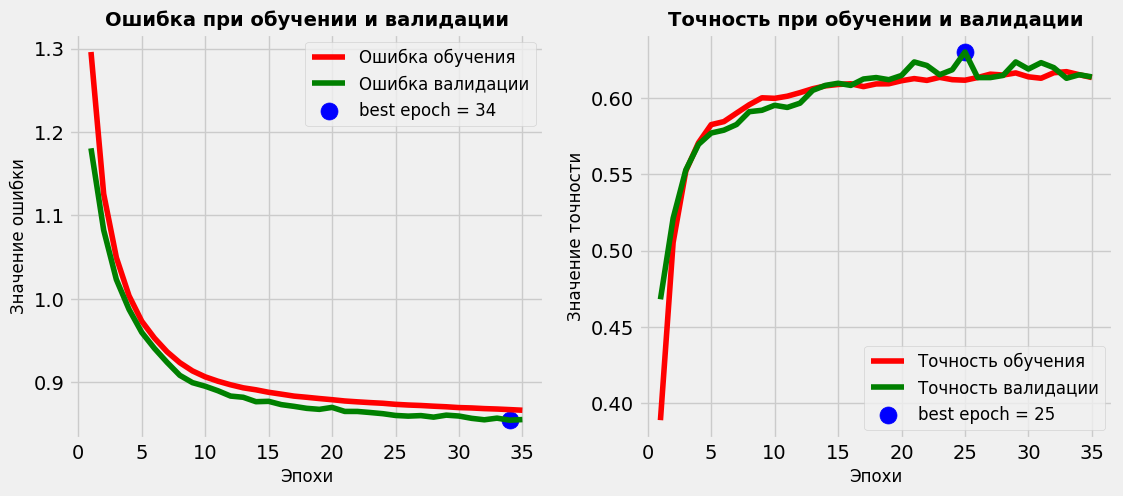

In [72]:
plot_training_curves(history1_new_df)

In [73]:
y_predicted_prob = model1_new_df.predict(X_test) # обучения модели на тестовом наборе
y_predicted = np.argmax(y_predicted_prob, axis=1) # перевод вероятностей в метки [0, 1] с порогом 0.5

84/84 [==============================] - 0s 4ms/step


In [74]:
model1_new_df_performance = generate_preformance_scores(y_test, y_predicted, y_predicted_prob)

Accuracy Score:		0.6196
Precision_score:	0.6120
Recall_score:		0.6196
AUC Score:		0.8526

Accuracy Score 0:	0.7656
Accuracy Score 1:	0.4094
Accuracy Score 2:	0.4992
Accuracy Score 3:	0.8042

              precision    recall  f1-score   support

           0       0.63      0.77      0.69       674
           1       0.46      0.41      0.43       679
           2       0.59      0.50      0.54       657
           3       0.77      0.80      0.79       669

    accuracy                           0.62      2679
   macro avg       0.61      0.62      0.61      2679
weighted avg       0.61      0.62      0.61      2679



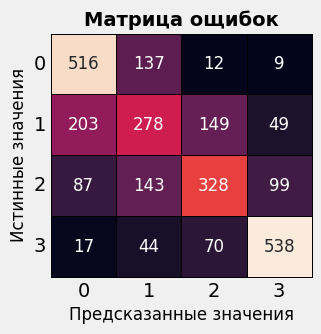

In [75]:
plot_confusion_matrix(y_test, y_predicted, figsize=(3, 3))

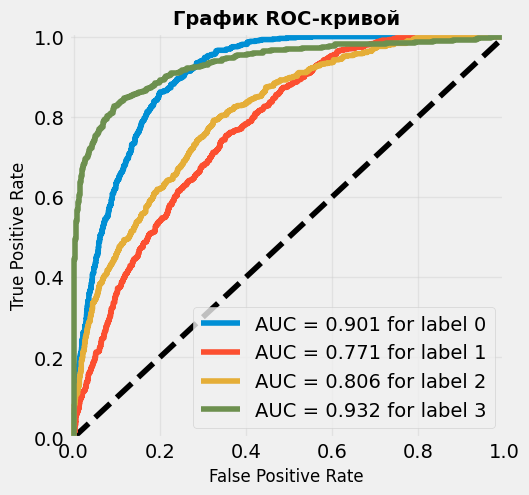

In [76]:
plot_multiclass_roc(y_test, y_predicted_prob, 4)

In [77]:
# сведем результаты работы всех моделей в таблицу
performance_df = pd.DataFrame({
    'Модель 1': model1_rms_preformance,
    'Модель 2': model1_new_df_performance
}).T

performance_df

,accuracy_score,precision_score,recall_score,auc_score
Модель 1,0.735957,0.743407,0.736096,0.912558
Модель 2,0.619607,0.611988,0.619634,0.852569


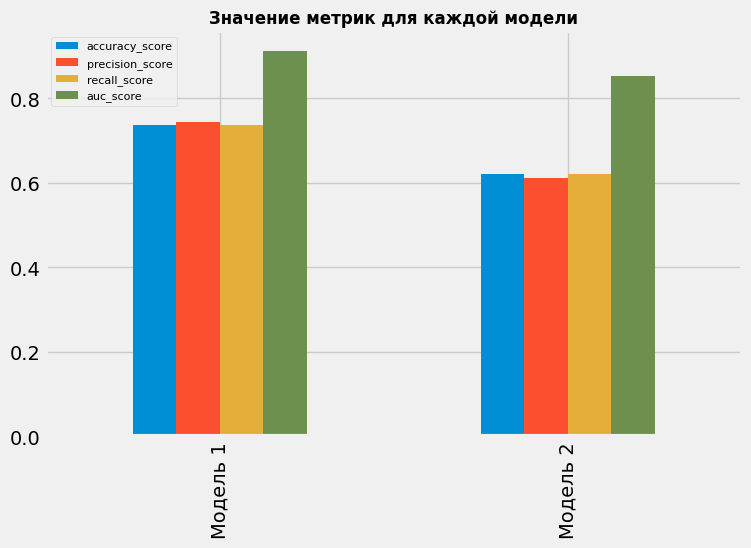

In [85]:
performance_df.plot(kind="bar", figsize=(8, 5))
plt.title('Значение метрик для каждой модели', fontsize=12, fontweight="bold");
plt.legend(loc=2, fontsize=8)